# State class
틱택토 상태를 나타낼 수 있는 class를 만들어 주세요.

- 2명의 플레이어가 있고, 각 플레이어의 수가 뭔지 식별가능해야 합니다.  

**꼭 구현해야할 매소드(주니어/시니어 공통)**
- 둘 수 있는 위치가 어딘지 알려주는 함수
- win / lose / draw(무승부)를 식별해주는 함수
- render 함수

**min-max algorithm / alpha-beta algorithm 구현(시니어)**

### 🚨 만약 감이 안 온다면 운영진에게 연락주시면 참고할 만한 레퍼런스를 보내드리겠습니다.
### 🚨 참고한 레퍼런스가 있다면, 출처를 남겨주세요.



---



# 틱택톡의 state
- 0: 빈 칸
- 1: 플레이어 1의 기호 (X)
- -1: 플레이어 2의 기호 (O)

# 틱택톡의 Action Space
- 3x3 보드의 각 칸, 빈 좌표
- A = {(0,0),(0,1) ,.., (2,2)}

## get_possible_moves 함수
- 빈 칸의 좌표들이 담긴 moves 리스트를 반환

## check_winner함수
- 가로, 세로, 대각선을 확인
- 승자 or 무승부 반환

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
import numpy as np

# 하이퍼 파라미터
BOARD_SIZE = 3
PLAYER_1 = 1
PLAYER_2 = 2

class TicTacToeState:
    def __init__(self):
        # 3x3 보드, 0은 빈 칸, PLAYER_1은 플레이어 1, PLAYER_2는 플레이어 2를 나타낸다.
        self.board = np.zeros((BOARD_SIZE, BOARD_SIZE), dtype=int)
        self.current_player = PLAYER_1  # 1번 플레이어가 먼저 시작

    def get_available_actions(self):
        # 보드에서 빈 칸(0)을 찾아 그 좌표를 리스트로 반환
        return [(i, j) for i in range(BOARD_SIZE) for j in range(BOARD_SIZE) if self.board[i, j] == 0]

    def check_win(self):
        # 가로, 세로, 대각선에 대해 승리를 확인
        for i in range(BOARD_SIZE):
            # 가로 확인
            if self.board[i, 0] == self.board[i, 1] == self.board[i, 2] != 0:
                return self.board[i, 0]
            # 세로 확인
            if self.board[0, i] == self.board[1, i] == self.board[2, i] != 0:
                return self.board[0, i]

        # 대각선 확인
        if self.board[0, 0] == self.board[1, 1] == self.board[2, 2] != 0:
            return self.board[0, 0]
        if self.board[0, 2] == self.board[1, 1] == self.board[2, 0] != 0:
            return self.board[0, 2]

        # 승리가 없으면 None 반환
        return None

    def check_draw(self):
        # 보드에 빈 칸이 없고, 승자가 없는 경우 무승부
        return np.all(self.board != 0) and self.check_win() is None

    def render(self):
    # 보드를 출력하여 현재 상태를 보여줌
        for i, row in enumerate(self.board):
            print(' | '.join([str(x) if x != 0 else ' ' for x in row]))
            if i < BOARD_SIZE - 1:
                print('---------')



    def make_move(self, row, col):
        # 현재 플레이어의 차례에 해당 칸이 비어 있으면 수를 둔다.
        if self.board[row, col] == 0:
            self.board[row, col] = self.current_player
            self.current_player = PLAYER_2 if self.current_player == PLAYER_1 else PLAYER_1  # 플레이어 교체
        else:
            raise ValueError("해당 위치에 둘 수 없습니다.")

    def is_game_over(self):
        # 승리 또는 무승부로 게임이 끝났는지 확인
        if self.check_win() is not None or self.check_draw():
            return True
        return False

In [8]:
# 하이퍼 파라미터
REWARD_WIN = 1
REWARD_LOSE = -1
REWARD_DRAW = 0.5
REWARD_NONE = 0

class TicTacToeEnvironment:
    def __init__(self):
        self.state = TicTacToeState()

    def reset(self):
        # 환경을 초기 상태로 재설정하고 초기 상태 반환
        self.state = TicTacToeState()
        return self.state.board

    def step(self, action):
        # 주어진 행동(action)을 받아 다음 상태와 보상을 반환
        row, col = action
        self.state.make_move(row, col)

        # 게임이 끝났는지 여부 확인
        done = self.state.is_game_over()
        winner = self.state.check_win()

        # 보상 계산
        if winner == PLAYER_1:
            reward = REWARD_WIN if self.state.current_player == PLAYER_2 else REWARD_LOSE
        elif winner == PLAYER_2:
            reward = REWARD_WIN if self.state.current_player == PLAYER_1 else REWARD_LOSE
        elif self.state.check_draw():
            reward = REWARD_DRAW
        else:
            reward = REWARD_NONE

        # 현재 상태(board), 보상, 게임 종료 여부, 추가 정보 반환
        return self.state.board, reward, done, {}

    def render(self):
        # 보드를 렌더링
        self.state.render()

    def get_available_actions(self):
        # 가능한 행동들을 반환
        return self.state.get_available_actions()

# 몬테카를로 에이전트

 - 에피소드 단위로 보상을 누적하여 정책을 업데이트하는 방법
 - 에피소드가 끝난 후 상태-행동 쌍에 대한 반환값(G)을 계산하여, 그 정보를 이용해 Q 값을 업데이트합니다. 즉, 미래의 보상을 포함한 총 보상을 계산하고, 이를 기반으로 상태-행동 가치 함수(Q)를 갱신하는 방식으로 몬테카를로 방법을 적용

In [4]:
import random
from collections import defaultdict

EPSILON = 0.1  # 탐험 확률
DISCOUNT_FACTOR = 0.9  # 할인율

class MonteCarloAgent:
    def __init__(self, player, epsilon=EPSILON, discount_factor=DISCOUNT_FACTOR):
        # 상태-행동 가치 함수 Q 및 반환(리턴) 목록을 저장하는 딕셔너리
        self.Q = defaultdict(lambda: np.zeros((BOARD_SIZE, BOARD_SIZE)))
        self.returns = defaultdict(list)  # 각 상태-행동 페어의 반환값을 저장
        self.epsilon = epsilon  # 탐험 확률
        self.discount_factor = discount_factor  # 할인율
        self.player = player  # 플레이어 번호 (1 또는 2)

    def choose_action(self, state, available_actions):
        # 입실론 탐험 정책에 따라 행동 선택 (탐험 vs. 최적 정책)
        if random.uniform(0, 1) < self.epsilon:
            # 랜덤으로 탐험
            return random.choice(available_actions)
        else:
            # Q 값이 가장 높은 행동을 선택
            state_key = tuple(map(tuple, state))  # 상태를 불변형으로 변환하여 키로 사용
            q_values = np.array([self.Q[state_key][i, j] for i, j in available_actions])
            max_q_value = np.max(q_values)
            best_actions = [action for action, q in zip(available_actions, q_values) if q == max_q_value]
            return random.choice(best_actions)  # 최대 Q값을 가진 행동 중 하나를 선택

    def update_policy(self, episode):
        # 에피소드를 이용해 Q 값을 업데이트
        visited_states = set() # 상태-행동 쌍 중복 업데이트를 방지
        G = 0  # 반환 값 (리턴)

        # 에피소드를 뒤에서부터 거꾸로 순회하면서 리턴 값을 계산
        for state, action, reward in reversed(episode):
            state_key = tuple(map(tuple, state))
            G = self.discount_factor * G + reward # 리턴 값 G 계산

            if (state_key, action) not in visited_states: # 중복된 상태-행동 쌍은 제외
                visited_states.add((state_key, action))
                self.returns[(state_key, action)].append(G) # 리턴 값을 저장
                self.Q[state_key][action] = np.mean(self.returns[(state_key, action)]) # 평균 리턴으로 Q 값 업데이트

# AI & AI

In [6]:
def generate_episode(env, agent1, agent2):
    episode = []
    state = env.reset()
    done = False
    current_agent = agent1 if env.state.current_player == PLAYER_1 else agent2

    while not done:
        available_actions = env.get_available_actions()
        action = current_agent.choose_action(state, available_actions)
        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        current_agent = agent1 if env.state.current_player == PLAYER_1 else agent2

    return episode

def monte_carlo_control(env, agent1, agent2, num_episodes):
    for episode in range(num_episodes):
        episode_data = generate_episode(env, agent1, agent2)
        agent1.update_policy(episode_data)
        agent2.update_policy(episode_data)


env = TicTacToeEnvironment()
mc_agent_1 = MonteCarloAgent(player=PLAYER_1)
mc_agent_2 = MonteCarloAgent(player=PLAYER_2)

# num_episodes 에피소드 동안 학습
monte_carlo_control(env, mc_agent_1, mc_agent_2, num_episodes=5000)

# 학습 후 두 AI가 대결하는 코드
state = env.reset()
env.render()
done = False

while not done:
    available_actions = env.get_available_actions()
    if env.state.current_player == PLAYER_1:
        action = mc_agent_1.choose_action(state, available_actions)
    else:
        action = mc_agent_2.choose_action(state, available_actions)
    state, reward, done, _ = env.step(action)
    env.render()

# 최종 결과 출력
winner = env.state.check_win()
if winner == PLAYER_1:
    print("AI1 승리")
elif winner == PLAYER_2:
    print("AI2 승리")
else:
    print("무승부")

  |   |  
---------
  |   |  
---------
  |   |  
  |   |  
---------
1 |   |  
---------
  |   |  
2 |   |  
---------
1 |   |  
---------
  |   |  
2 |   |  
---------
1 | 1 |  
---------
  |   |  
2 | 2 |  
---------
1 | 1 |  
---------
  |   |  
2 | 2 |  
---------
1 | 1 |  
---------
  | 1 |  
2 | 2 |  
---------
1 | 1 |  
---------
  | 1 | 2
2 | 2 |  
---------
1 | 1 | 1
---------
  | 1 | 2
AI1 승리


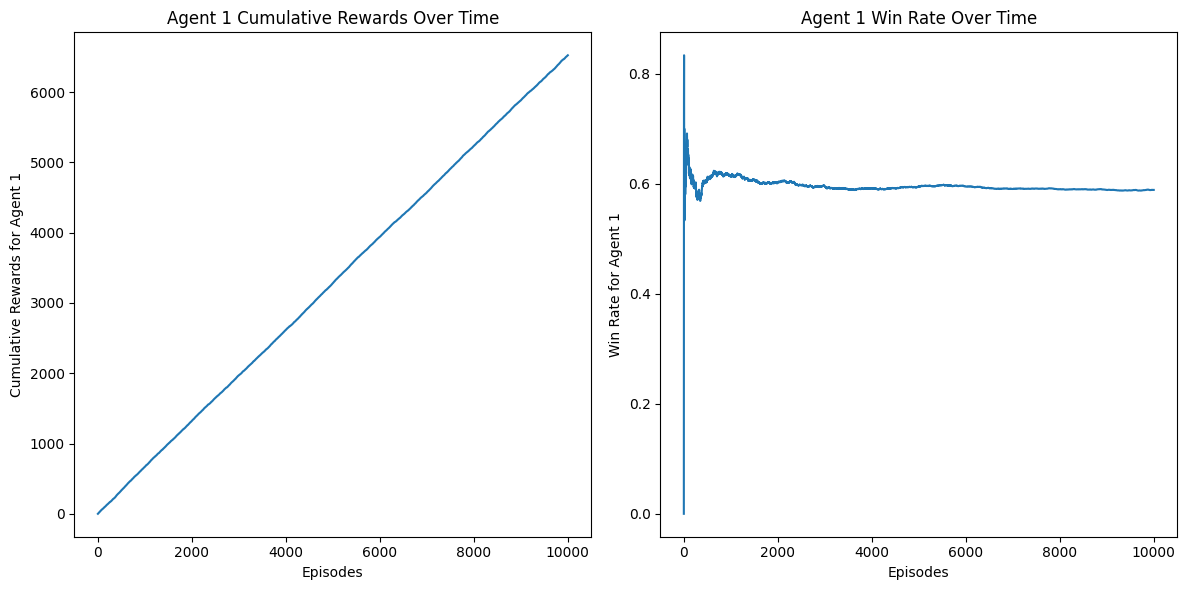

In [10]:
def simulate_cumulative_rewards_and_win_rate(env, agent1, agent2, num_episodes):
    agent1_cumulative_rewards = []
    agent1_win_rate = []
    cumulative_reward = 0
    agent1_wins = 0

    for episode in range(num_episodes):
        env.reset()
        done = False
        episode_reward = 0

        while not done:
            available_actions = env.get_available_actions()
            if env.state.current_player == PLAYER_1:
                action = agent1.choose_action(env.state.board, available_actions)
            else:
                action = agent2.choose_action(env.state.board, available_actions)
            _, reward, done, _ = env.step(action)

            # 에이전트 1의 턴에서 받은 보상 기록
            if env.state.current_player == PLAYER_2:  # 에이전트 1의 턴이 끝난 후
                episode_reward += reward

        # 에피소드마다 누적 보상 기록
        cumulative_reward += episode_reward
        agent1_cumulative_rewards.append(cumulative_reward)

        # 승리 여부 확인
        winner = env.state.check_win()
        if winner == PLAYER_1:
            agent1_wins += 1

        # 성공률 기록
        agent1_win_rate.append(agent1_wins / (episode + 1))

    return agent1_cumulative_rewards, agent1_win_rate

# 환경 초기화 및 에이전트 생성
env = TicTacToeEnvironment()
mc_agent_1 = MonteCarloAgent(player=PLAYER_1)
mc_agent_2 = MonteCarloAgent(player=PLAYER_2)

# 10000번의 게임을 시뮬레이션하여 에이전트 1의 누적 보상 및 성공률 시각화
num_episodes = 10000
agent1_cumulative_rewards, agent1_win_rate = simulate_cumulative_rewards_and_win_rate(env, mc_agent_1, mc_agent_2, num_episodes)

# 시각화
plt.figure(figsize=(12, 6))

# 누적 보상 그래프
plt.subplot(1, 2, 1)
plt.plot(range(num_episodes), agent1_cumulative_rewards)
plt.xlabel('Episodes')
plt.ylabel('Cumulative Rewards for Agent 1')
plt.title('Agent 1 Cumulative Rewards Over Time')

# 성공률 그래프
plt.subplot(1, 2, 2)
plt.plot(range(num_episodes), agent1_win_rate)
plt.xlabel('Episodes')
plt.ylabel('Win Rate for Agent 1')
plt.title('Agent 1 Win Rate Over Time')

plt.tight_layout()
plt.show()